<a href="https://colab.research.google.com/github/andersonmdcanteli/termo/blob/main/termo_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dominando o TERMO com Python!

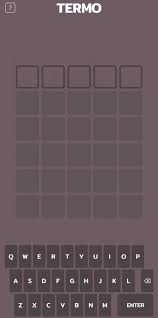

## Introdução

O [termo](https://term.ooo/) é um jogo simples, porém bastante divertido, onde o jogador tem até 6 chances para descobrir qual é a palavra de 5 letras do dia (o termo). É simple assim: uma palavra desconhecida de 5 letras, e você tem 6 chances de acertar a palavra. Após cada tentativa, o jogo da dicas de quão perto o jogador esta de acertar a palavra. As dicas são:

- Se uma letra ficar com fundo amarelo, significa que aquela letra faz parte da palavra, mas a posição da letra esta errada;
- Se uma letra ficar com fundo verde, significa que aquela letra faz parte da palavra e esta na posição correta;
- Se uma letra ficar com fundo preto, significa que a aquela letra não faz parte da palavra.

O jogo simula seu primo rico, o [Wordle](https://www.nytimes.com/games/wordle/index.html), e tem várias variantes em português, como o [termo.pt](https://termo.pt/), [palavra-do-dia.pt](https://palavra-do-dia.pt/), o [dueto](https://term.ooo/2/) que são 2 palavras que devem ser acertadas simultâneamente, o [quarteto](https://term.ooo/4/) que são 4 palavras que devem ser acertadas simultâneamente, além do infâme [xingo](https://xingo.site/) que a palavra é sempre uma palavra chula/baixo calão.

Apesar de simples, o jogo é bastante desafiador: além de ser necessário ter um bom repertório de palavras na ponta ~da língua~ dos dedos, uma boa estratégia de quais palavras chutar é importante para conseguir acertar a palavra. E é esta estratégia de qual palavra chutar que vamos estudar neste texto!



## Estratégia

A ideia é utilizar análise estatística para descobrir quais são as duas  palavras que tem a maior chance de serem um bom chute nas duas primeiras rodadas. Para isto, vou utilizar Python!

Por conhecimento geral, sabemos que palavras em português são predominante compostas pelas vogais `"a"`, `"e"` e `"o"`, além das consoantes `"r"` e `"s"`.  Depois destas letras, as vogais `"i"` e `"u"` são bastante comuns, além das consoantes `"c"`, `"t"`, `"n"`, `"m"`, etc. Mas será que isto é realmente verdade, ou apenas um viés pessoal? E, se for verdade, será que estas são as letras mais comuns em palavras de 5 letras? 

É preciso então determinar quais letras são mais frequentes no idioma português, para então descobrir quais palavras são bons chutes. Uma vez descoberto as letras mais frequentes, precismos de um forma de medir a chance de cada palavra ser um bom chute, o que podemos fazer somando as frequências de cada letra na palavra. 

Assim, precisamos saber qual a frequência de cada letra em um contexto geral, e depois medir a "força" de cada palavra.

O texto esta dividido desta forma:

1) Obtenção, limpeza e análise geral dos dados;

2) Cálculo das frequências das letras nas palavras;

3) Cálculo da "força" de cada palavra para o primeiro chute;

4) Cálculo da "força" de cada palavra para os dois primeiros chutes;

# 1) Obtenção, limpeza e análise geral dos dados

## Importações

Para fazer esta análise, vamos utilizar `pandas` e `numpy` para manipulação de dados, `SciPy` para análise estatística, e `matplotlib` e `seaborn` para desenhar alguns gráficos.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

### Versões

- Python verson: `3.7.13`
- Pandas version: `1.3.5`
- NumPy version: `1.21.6`
- matplotlib version: `3.2.2`
- seaborn version: `0.11.2`
- SciPy version: `1.7.3`

## Obtenção dos dados

Para descorbrir quais são as letras mais frequentes no português, precisamos de um conjunto de dados. Neste texto eu vou utilizar a lista de palavras do português brasileiro disponibilizada sob licença GNU pelo [IME](https://www.ime.usp.br/~pf/dicios/index.html). Este conjunto de dados tem quatro variantes, que diferem em relação ao uso de acentos e tremas nas palavras. 

Como o termo não considera acentos nas palavras, e assim não diferencia palavras como `estas` e `estás`, vou utilizar o data set `br-sem-acentos.txt`, onde as palavras não contém acentos, as palavras repetidas foram removidas, e estão em ordem alfabética.

Para importar estes dados como um `DataFramte` utilizamos o `pandas.read_csv()`:

In [ ]:
df = pd.read_csv("https://www.ime.usp.br/~pf/dicios/br-sem-acentos.txt", header=None, names=["palavras"])
df.describe()

,palavras
count,245366
unique,245366
top,a
freq,1


Este conjunto de dados tem um pouco do que 245 mil palavras, sendo que todas são únicas. As primeiras 10 palavras são:

In [ ]:
df.head(10)

,palavras
0,a
1,Aarao
2,aba
3,abacate
4,abacateiro
5,abacateiros
6,abacates
7,abacaxi
8,abacaxis
9,abaciais


## Limpeza dos dados

Sempre é importante fazer um pré-processamento antes de analisa-los efetivamente, de forma a verificar se eles estão condizentes com as nossas premissas (no caso, os jogo termo).


### Checando a presença de nomes

Inicialmente, podemos observar que temos *nomes* no conjunto de dados. Observe o nome `Aarao` (índice `1`), que inicia com letra maiúscula. Vamos verificar quantos nomes temos no conjunto de dados, admitindo que os nomes sempre iniciam em letra maiúscula e todas as demais palavras são minúsculas.

Isto é feito de forma bastante simples através do médoto `str.istitle()` que retorna `True` caso a `str` tenha apenas a primeira palavra em maiúsculo. Caso contrário, retorna `False`. Assim


In [ ]:
df['is_name'] = df['palavras'].str.istitle()
df.head()

,palavras,is_name
0,a,False
1,Aarao,True
2,aba,False
3,abacate,False
4,abacateiro,False


Para fazer uma investigação mais adequada, vou criar um novo `DataFrame com apenas os nomes filtrados:

In [ ]:
df_nome = df.loc[df['is_name'] == True].copy()
df_nome.reset_index(drop=True, inplace=True)
df_nome.head()

,palavras,is_name
0,Aarao,True
1,Abel,True
2,Abelardo,True
3,Abissinia,True
4,Abner,True


In [ ]:
df_nome.describe()

,palavras,is_name
count,755,755
unique,755,1
top,Aarao,True
freq,1,755


Este recorte do cojunto de dados contém `755` palavras que iniciam com letra maiúscula e tem as demais letras na forma minúscula. Como o termo não utiliza nomes, é importante remover estas entradas do conjunto de dados.

Para isto, podemos utilizar um filtro nos casos onde a coluna `is_name==False` no `DataFrame` `df`. Assim:

In [ ]:
df = df[df['is_name'] == False]
df.head(10)

,palavras,is_name
0,a,False
2,aba,False
3,abacate,False
4,abacateiro,False
5,abacateiros,False
6,abacates,False
7,abacaxi,False
8,abacaxis,False
9,abaciais,False
10,abacial,False


Observe que a entrada do índice 1 (Aarao) foi removida. O tamanho do conjunto de dados reduziu de 245366 para 244611, como esperado.

In [ ]:
df.describe()

,palavras,is_name
count,244611,244611
unique,244611,1
top,a,False
freq,1,244611


In [ ]:
df.shape[0] + df_nome.shape[0]

245366

### Checando a presença de dados não alfabéticos

Também é importante verificar se as entradas contém apenas letras. Isto é facilmente feito através do método `str.isalpha`, que retorna `True` apenas se a `str` for composta apenas por letras.

In [ ]:
df['is_alpha'] = df['palavras'].str.isalpha()
df.head()

,palavras,is_name,is_alpha
0,a,False,True
2,aba,False,True
3,abacate,False,True
4,abacateiro,False,True
5,abacateiros,False,True


In [ ]:
df_is_alpha = df.loc[df['is_alpha'] == False].copy()
df_is_alpha.reset_index(drop=True, inplace=True)
df_is_alpha.head(10)

,palavras,is_name,is_alpha


In [ ]:
df_is_alpha.describe()

,palavras,is_name,is_alpha
count,0,0,0
unique,0,0,0
top,NaN,NaN,NaN
freq,NaN,NaN,NaN


Portanto, todas as entradas contém apenas letras, e não precisamos alterar o conjunto de dados neste caso.

### Checando a presença de SIGLAS

Temos ainda que verificar se existem siglas no conjunto de dados (todas as palavras em maiúsculo). Isto pode ser feito através do método `str.isupper()`, que retorna `True` apenas se todas as letras da `str` forem maiúsculas.

In [ ]:
df['is_upper'] = df['palavras'].str.isupper()
df.head()

,palavras,is_name,is_alpha,is_upper
0,a,False,True,False
2,aba,False,True,False
3,abacate,False,True,False
4,abacateiro,False,True,False
5,abacateiros,False,True,False


In [ ]:
df_is_upper = df.loc[df['is_upper'] == True].copy()
df_is_upper.reset_index(drop=True, inplace=True)
df_is_upper.head(10)

,palavras,is_name,is_alpha,is_upper
0,AC,False,True,True
1,BC,False,True,True
2,EUA,False,True,True
3,HIV,False,True,True
4,IBM,False,True,True
5,IM,False,True,True
6,IMPA,False,True,True
7,MDC,False,True,True
8,MERCOSUL,False,True,True
9,SBM,False,True,True


In [ ]:
df_is_upper.describe()

,palavras,is_name,is_alpha,is_upper
count,14,14,14,14
unique,14,1,1,1
top,AC,False,True,True
freq,1,14,14,14


O conjunto de dados contém 14 siglas. Siglas tem sequência de letras diferenciada das demais palavras, sem necessariamente respeitar a grafia correta da lingua portuguesa. Portanto, as 14 siglas não devem ser mantidas no conjunto de dados.

In [ ]:
df = df[df['is_upper'] == False]
df.head(10)

,palavras,is_name,is_alpha,is_upper
0,a,False,True,False
2,aba,False,True,False
3,abacate,False,True,False
4,abacateiro,False,True,False
5,abacateiros,False,True,False
6,abacates,False,True,False
7,abacaxi,False,True,False
8,abacaxis,False,True,False
9,abaciais,False,True,False
10,abacial,False,True,False


In [ ]:
df.shape[0] + df_nome.shape[0] + df_is_upper.shape[0]

245366

Com isto finalizamos esta avaliação inicial dos dados. Vou apenas remover as colunas criadas e ficar apenas com a coluna `'palavras'`:

In [ ]:
df = df.drop(['is_name',	'is_alpha',	'is_upper'], axis=1)
df.reset_index(drop=True, inplace=True)
df.head()

,palavras
0,a
1,aba
2,abacate
3,abacateiro
4,abacateiros


In [ ]:
df.describe()

,palavras
count,244597
unique,244597
top,a
freq,1


## Análise geral dos dados

Agora que já foi realizado uma limpeza nos dados, devemos fazer uma breve análise dos dados. Como vamos trabalhar com as palavras, é importante ter uma ideia da froma distribuição da quantidade de letras das palavras contidas no conjunto de dados.

Como as `str` em Python são sequências, o número de letras de uma palavra é facilmente obtida através do método `str.len()`. Podemos armazenar estas informações em uma nova coluna no `DataFrame` (`"count"`):

In [ ]:
df['count'] = df['palavras'].str.len()
df.head()

,palavras,count
0,a,1
1,aba,3
2,abacate,7
3,abacateiro,10
4,abacateiros,11


Agora podemos desenhar um histrograma com o número de letras em cada palavra:

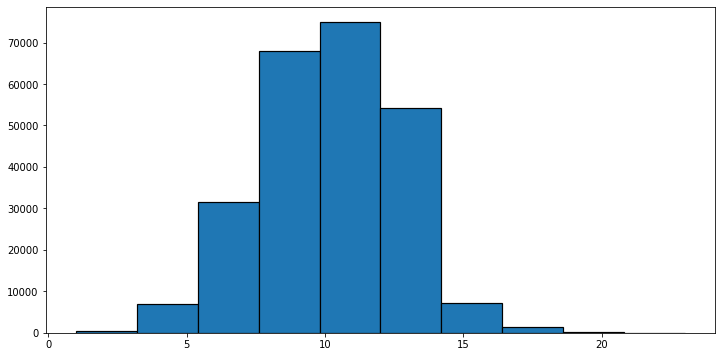

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(df['count'], edgecolor='black', linewidth=1.2)
plt.show()

In [ ]:
scipy.stats.anderson(df['count'])

AndersonResult(statistic=1699.934061248845, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Os dados apresentam uma distribuição aparentemente Normal, com as palavras tendo em média aproximadamente 10 letras. Mais informações sobre os dados é facilmente obtida através do método `describe()`:

In [ ]:
df.describe()

,count
count,244597.000000
mean,9.951553
std,2.466147
min,1.000000
25%,8.000000
50%,10.000000
75%,12.000000
max,23.000000


A palavras deste conjunto de dados tem tamanho variando entre 1 e 23 letras. Para saber quais palavras são as de 23 letras, podemos utilizar um filtro na coluna `"count"`:

In [ ]:
df[df['count'] == 23 ]

,palavras,count
60243,constitucionalizariamos,23
60252,constitucionalizassemos,23
150837,interdisciplinariedades,23


Assim, temos 3 palavras com 23 letras cada, que são as três palavras com maior número de letras. Dessa forma, descobrimos que o conjunto de dados não tem todas as palavras da língua portuguesa, pois a palavra mais longa do idioma português é `'pneumoultramicroscopicossilicovulcanoconiótico'` com 46 letras ([BBC](https://www.bbc.com/portuguese/curiosidades-43938059)). De qualquer forma, temos um conjunto de dados grande o suficiente (com `244597` palavras).

# 2) Cálculo das frequências das letras nas palavras

Agora vamos estimar a frequência de cada letra nas palavras, considerando todas as palavras do conjunto de dados. 

## Dividindo as palavras em letras

Para determinar a frequência das letras em cada palavra, precisamos conta-las! Para isto, vou dividir cada palavra em um letra, aplicando `list` em cada linha do `df`:


In [ ]:
df['letras'] = df['palavras'].apply(list)
df.head()

,palavras,count,letras
0,a,1,[a]
1,aba,3,"[a, b, a]"
2,abacate,7,"[a, b, a, c, a, t, e]"
3,abacateiro,10,"[a, b, a, c, a, t, e, i, r, o]"
4,abacateiros,11,"[a, b, a, c, a, t, e, i, r, o, s]"


Como vamos determinar a frequência das letras, é mais simples criar um novo `DataFrame` (`df_letras`) com apenas as letras de cada palavra em cada coluna:

In [ ]:
df_letras = pd.DataFrame(df['letras'].to_list(), columns=np.arange(1,df['count'].max()+1)).copy()
df_letras.head()

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
0,a,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,a,b,a,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,a,b,a,c,a,t,e,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,a,b,a,c,a,t,e,i,r,o,...,None,None,None,None,None,None,None,None,None,None
4,a,b,a,c,a,t,e,i,r,o,...,None,None,None,None,None,None,None,None,None,None


Agora é preciso contar o número de ocorências de cada letra. Com `pandas` isto é muito simples, pois temos a função `pd.value_counts` que podemos aplicar em um dataframe. Assim:

In [ ]:
df_letras = df_letras.apply(pd.value_counts)
df_letras.head()

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
C,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a,34966.0,27566.0,16801.0,31618.0,33904.0,39144.0,47874.0,41042.0,34766.0,22569.0,...,1692.0,672.0,228.0,142.0,21.0,11.0,7.0,NaN,NaN,NaN
b,6776.0,3806.0,8557.0,3879.0,3560.0,2349.0,1076.0,412.0,295.0,127.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observe que no dataframe temos as letras `'C'`, `'N'` e `'P'` maiúsculas, que não deveriam estar no conjunto de dados (pois removemos as palavras que iniciam em maiúsculo e também as palavras que contém apenas letras maiusculas. 

A letra `'C'` é a primeira letra da palavra, então é simples descobrir sua origem. Para isto, podemos utilizar o método `str.startswith()`

In [ ]:
df[df['palavras'].str.startswith("C")]

,palavras,count,letras
51751,CNPq,4,"[C, N, P, q]"


A sigla `CNPq` acabou não sendo removida, pois ela não contém apenas letras em maiúsculo. Vamos remover esta entrada do `DataFrame` `df`:

In [ ]:
df.drop(df[df['palavras'] == "CNPq"].index, inplace=True, axis=0)
df.reset_index(inplace=True, drop=True)
df.shape

(244596, 3)

Como removemos uma enstra, é preciso refazer o dataframe `df_letras` e verificar se algum caracter equivocado ficou de fora

In [ ]:
df_letras = pd.DataFrame(df['letras'].to_list(), columns=np.arange(1,df['count'].max()+1)).copy()
df_letras = df_letras.apply(pd.value_counts)
df_letras.head(30)

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
a,34966,27566.0,16801.0,31618.0,33904.0,39144.0,47874.0,41042.0,34766.0,22569.0,...,1692.0,672.0,228.0,142.0,21.0,11.0,7.0,NaN,NaN,NaN
b,6776,3806.0,8557.0,3879.0,3560.0,2349.0,1076.0,412.0,295.0,127.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c,25455,4325.0,16391.0,12138.0,9472.0,9922.0,8486.0,7069.0,3417.0,2141.0,...,65.0,21.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
d,27289,2644.0,6507.0,6360.0,6002.0,7573.0,6543.0,6116.0,4835.0,3460.0,...,195.0,81.0,40.0,17.0,5.0,4.0,2.0,2.0,NaN,NaN
e,31931,54523.0,13628.0,30271.0,25823.0,22181.0,24146.0,21398.0,20169.0,17292.0,...,1767.0,676.0,325.0,171.0,61.0,17.0,9.0,3.0,2.0,NaN
f,8747,2739.0,6070.0,3861.0,2733.0,2980.0,1152.0,874.0,506.0,146.0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
g,4254,1831.0,7374.0,5813.0,5053.0,5525.0,1981.0,1465.0,576.0,88.0,...,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
h,2105,1894.0,296.0,2435.0,1651.0,3264.0,3307.0,2081.0,1072.0,483.0,...,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
i,12161,16332.0,12029.0,24080.0,26974.0,27065.0,26620.0,21111.0,19040.0,12753.0,...,1273.0,623.0,212.0,97.0,39.0,14.0,3.0,2.0,NaN,NaN
j,965,531.0,1417.0,1149.0,1317.0,1537.0,852.0,453.0,141.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Agora todos os índices são compostos por letras em minúsculo, e cada coluna apresenta a contagem de de cada letra na sua posição. Por exemplo, a letra `z` é a primeira letra em 559 palavras, é a segunda letra em 362 vezes, é a terceira letra em 862 palavras, etc.

Observe que não temos nenhuma palavra com a letra `"y"`.

## Obtendo as frequências 


Para obter a frequência que cada letra ocorre nas palavras, basta saber o número de vezes que a letra ocorre, e dividir pelo número total de letras de todas as lavras. 

O `DataFrame` `df_letras` contém a contagem das letras em cada posção. Para saber o número total de ocorrências de cada letra, basta somar cada linha do `DataFrame`. Para isto, basta utilizar o método `sum()`

In [ ]:
df_letras['soma'] = df_letras.sum(axis=1)
df_letras['soma'].head(10)

a    358639.0
b     30843.0
c    100280.0
d     81048.0
e    287583.0
f     29907.0
g     34127.0
h     18768.0
i    218560.0
j      8464.0
Name: soma, dtype: float64

Portanto, o conjunto de dados contém `358639` letras `'a'`,  `30843` letras `'b'`, `100280` letras `'c'`, e assim por diante. Uma forma melhor de verificar isto é através de um gráfico de barras:

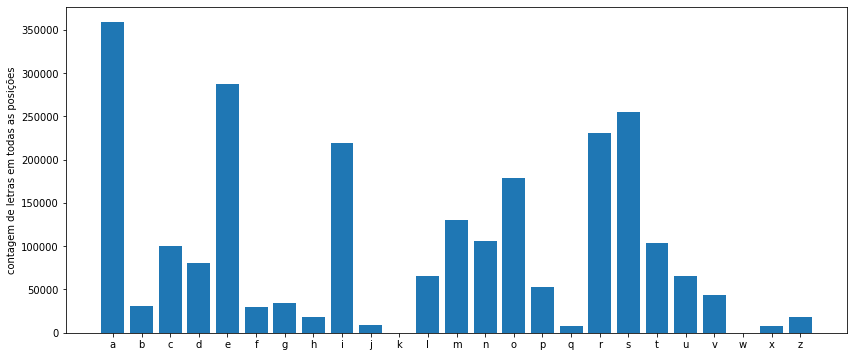

In [ ]:
plt.figure(figsize=(14,6))
plt.bar(df_letras.index, df_letras['soma'])
plt.ylabel("contagem de letras em todas as posições")
plt.show()

Para melhorar a visualização, podemos ordenar os dados de acordo com a coluna `"soma"`:

In [ ]:
df_sorted_full = df_letras.copy()
df_sorted_full = df_sorted_full.sort_values(by="soma", ascending=False)
df_sorted_full.head()

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,soma
a,34966,27566.0,16801.0,31618.0,33904.0,39144.0,47874.0,41042.0,34766.0,22569.0,...,672.0,228.0,142.0,21.0,11.0,7.0,NaN,NaN,NaN,358639.0
e,31931,54523.0,13628.0,30271.0,25823.0,22181.0,24146.0,21398.0,20169.0,17292.0,...,676.0,325.0,171.0,61.0,17.0,9.0,3.0,2.0,NaN,287583.0
s,12819,12785.0,29421.0,10723.0,11861.0,15044.0,18477.0,22814.0,25638.0,26416.0,...,3907.0,1784.0,742.0,307.0,137.0,49.0,15.0,6.0,3.0,254777.0
r,21230,21805.0,23801.0,22445.0,30238.0,26784.0,22142.0,24113.0,16906.0,11489.0,...,232.0,86.0,NaN,20.0,NaN,NaN,NaN,NaN,NaN,230996.0
i,12161,16332.0,12029.0,24080.0,26974.0,27065.0,26620.0,21111.0,19040.0,12753.0,...,623.0,212.0,97.0,39.0,14.0,3.0,2.0,NaN,NaN,218560.0


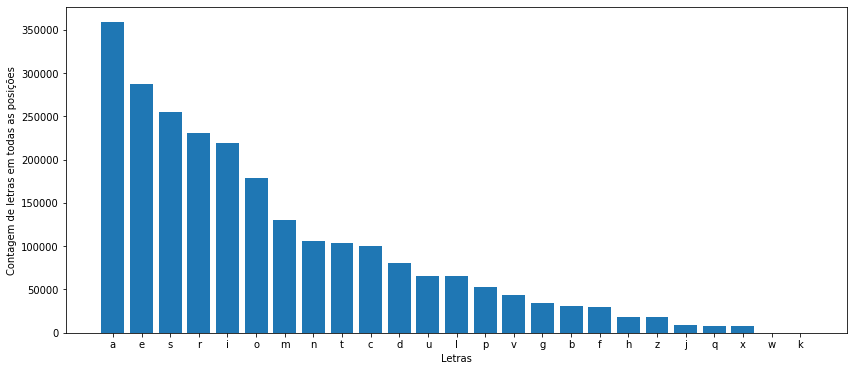

In [ ]:
plt.figure(figsize=(14,6))
plt.bar(df_sorted_full.index, df_sorted_full['soma'])
plt.ylabel("Contagem de letras em todas as posições")
plt.xlabel("Letras")
plt.show()

Assim, a letra mais utilzada é a letra `'a'`, seguido das letras `'e'`, `'s'` e `'r'`, como o esperado. As letras menos frequentes são as letras `'k'` e `'w'`. 

Para estimar a probabilidade de cada letra ocorrer em uma palavra, basta dividir a ocorrência pelo número total de letras. O total de letras é a soma da coluna `'soma'`:

In [ ]:
total_letras = df_letras['soma'].sum()
total_letras

2434116.0

Agpra é só calcular a probabilidade para cada letra:

In [ ]:
df_sorted_full['freq'] = df_sorted_full['soma']/total_letras
df_sorted_full['freq'].head()

a    0.147338
e    0.118147
s    0.104669
r    0.094899
i    0.089790
Name: freq, dtype: float64

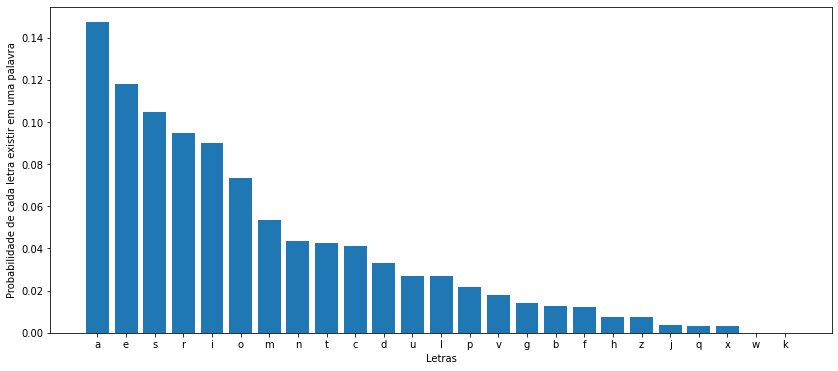

In [ ]:
plt.figure(figsize=(14,6))
plt.bar(df_sorted_full.index, df_sorted_full['freq'])
plt.ylabel("Probabilidade de cada letra existir em uma palavra")
plt.xlabel("Letras")
plt.show()

Poderíamos utilizar estes dados para calcular a "força" de cada palavra. Contudo, este resultado é para palavras de tamanho entre `1` e `23`, mas o termo somente utiliza palavras de 5 letras. Será que a frequência é similar? Vamos descobrir!


## Estimando a frequência para o termo

Começamos criando um novo `DataFrame` a partir do `DataFrame` `df`, mas limitado para palavras com `5`letras:

In [ ]:
df_termo = df.loc[df['count'] == 5].copy()
df_termo.reset_index(inplace=True, drop=True)
df_termo.head()

,palavras,count,letras
0,abaco,5,"[a, b, a, c, o]"
1,abade,5,"[a, b, a, d, e]"
2,abafa,5,"[a, b, a, f, a]"
3,abafe,5,"[a, b, a, f, e]"
4,abafo,5,"[a, b, a, f, o]"


Agora é preciso contar o número de letras em cada palavra. Basta seguir os passos anteriores:

In [ ]:
df_termo_letras = pd.DataFrame(df_termo['letras'].to_list(), columns=np.arange(1,6))
df_termo_letras = df_termo_letras.apply(pd.value_counts)
df_termo_letras.head(30)

,1,2,3,4,5
a,576,1001,330,1153.0,1115.0
b,272,52,117,78.0,NaN
c,538,64,282,192.0,NaN
d,229,59,207,248.0,NaN
e,177,856,281,808.0,571.0
f,360,47,91,29.0,NaN
g,208,34,215,129.0,NaN
h,40,46,29,116.0,NaN
i,105,627,484,447.0,460.0
j,68,8,70,57.0,NaN


Agora somamos todas as ocorrências:

In [ ]:
df_termo_letras['soma'] = df_termo_letras.sum(axis=1)
df_termo_letras.head(30)

,1,2,3,4,5,soma
a,576,1001,330,1153.0,1115.0,4175.0
b,272,52,117,78.0,NaN,519.0
c,538,64,282,192.0,NaN,1076.0
d,229,59,207,248.0,NaN,743.0
e,177,856,281,808.0,571.0,2693.0
f,360,47,91,29.0,NaN,527.0
g,208,34,215,129.0,NaN,586.0
h,40,46,29,116.0,NaN,231.0
i,105,627,484,447.0,460.0,2123.0
j,68,8,70,57.0,NaN,203.0


E então calculamos a probabilidade de cada letra ocorrer:

In [ ]:
total_letras = df_termo_letras['soma'].sum()
total_letras

26750.0

In [ ]:
df_termo_letras['frequencia'] = df_termo_letras['soma']/total_letras
df_termo_letras.head()

,1,2,3,4,5,soma,frequencia
a,576,1001,330,1153.0,1115.0,4175.0,0.156075
b,272,52,117,78.0,NaN,519.0,0.019402
c,538,64,282,192.0,NaN,1076.0,0.040224
d,229,59,207,248.0,NaN,743.0,0.027776
e,177,856,281,808.0,571.0,2693.0,0.100673


E podemos plotar um gráfico de barras para uma melhor visualização

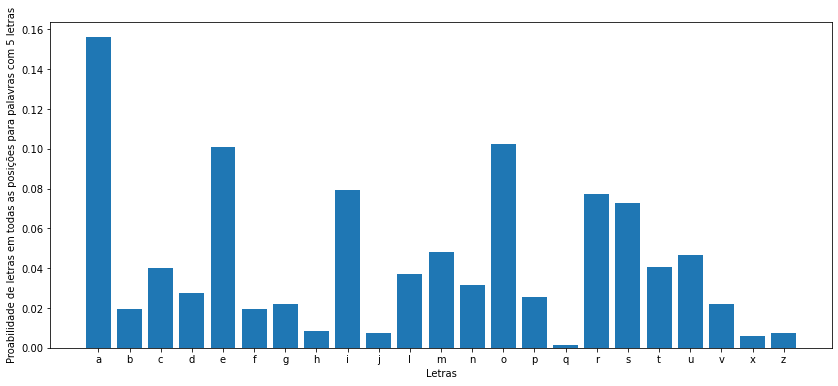

In [ ]:
plt.figure(figsize=(14,6))
plt.bar(df_termo_letras.index, df_termo_letras['frequencia'])
plt.ylabel("Proabilidade de letras em todas as posições para palavras com 5 letras")
plt.xlabel("Letras")
plt.show()

In [ ]:
df_sorted = df_termo_letras.copy()
df_sorted = df_sorted.sort_values(by="frequencia", ascending=False)
df_sorted.head()

,1,2,3,4,5,soma,frequencia
a,576,1001,330,1153.0,1115.0,4175.0,0.156075
o,147,894,161,489.0,1045.0,2736.0,0.102280
e,177,856,281,808.0,571.0,2693.0,0.100673
i,105,627,484,447.0,460.0,2123.0,0.079364
r,359,443,651,312.0,303.0,2068.0,0.077308


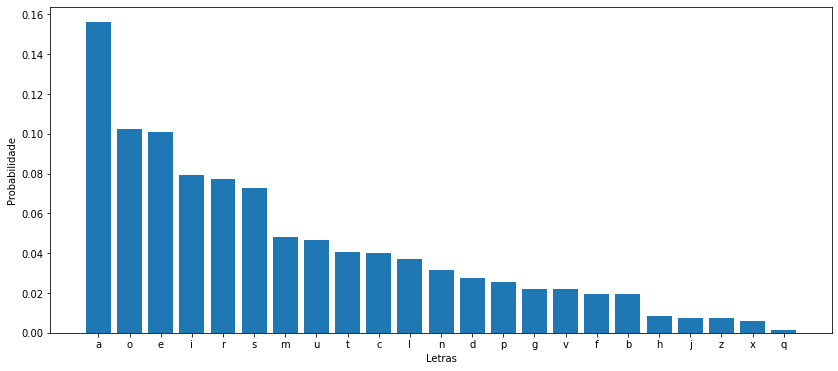

In [ ]:
plt.figure(figsize=(14,6))
plt.bar(df_sorted.index, df_sorted['frequencia'])
plt.ylabel("Probabilidade")
plt.xlabel("Letras")
plt.show()

Observe que temos uma frequência um pouco diferente da obtida para todas as palavras. Para uma melhor observação, vou concatenar os resultados obtidos em um único `DataFrame` para desenhar um gráfico de barras combinado

In [ ]:
df_comp = pd.concat([df_sorted['frequencia'], df_sorted_full['freq']], axis=1)
df_comp = df_comp.rename({'frequencia': "Termo", "freq": "Completo"}, axis=1)
df_comp.head(30)


,Termo,Completo
a,0.156075,0.147338
o,0.102280,0.073346
e,0.100673,0.118147
i,0.079364,0.089790
r,0.077308,0.094899
s,0.072860,0.104669
m,0.047888,0.053461
u,0.046542,0.026975
t,0.040710,0.042473
c,0.040224,0.041198


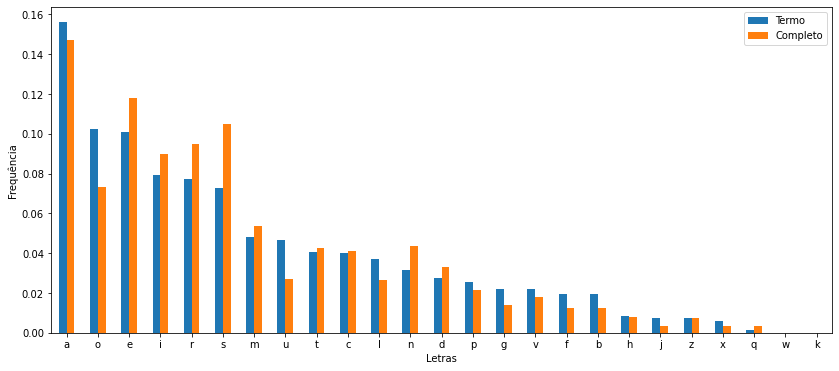

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
df_comp.plot.bar(ylabel="Frequência", xlabel="Letras", ax=ax, rot=0)
plt.show()

Observe que nenhuma palavras de 5 letras possui as letras `'w'` e `'k'`, além da letra `"y"` que não constava em nenhuma palavra do conjunto completo.



## Frequência por posição

No cálculo da frequência feito até agora, foi considerado a frequência de cada letra foi calculada desconsiderando a posição das letras nas palavras. Dessa forma, anagramas terão a mesma força, o que talvez não seja verdade. 

Vamos utilizar como exemplo a letra `"a"`: o número de ocorrências por posição desta letra é:

In [ ]:
df_termo_letras[df_termo_letras.index.str.startswith("a")]

,1,2,3,4,5,soma,frequencia
a,576,1001,330,1153.0,1115.0,4175.0,0.156075


Assim, a letra `"a"` aparece mais vezes nas posições 4, 5 e 2. Logo, se estimarmos a probabilidade considerando a frequência da posição das letras nas palavras, aumentamos a chance de acertar a letra e a sua posição. Parece promissor, não?

Vamos verificar se este comportamento também ocorre nas demais letras. Para isto, vou desenhar um heatmap relacionando a ocorrência de cada letra em cada posição.

Para facilitar, vou criar um novo `DataFrame` com o somatório de cada letra em sua respectiva posição

In [ ]:
df_termo_letras_posicao = df_termo_letras[[1, 2, 3, 4, 5]].copy()
df_termo_letras_posicao.head()

,1,2,3,4,5
a,576,1001,330,1153.0,1115.0
b,272,52,117,78.0,NaN
c,538,64,282,192.0,NaN
d,229,59,207,248.0,NaN
e,177,856,281,808.0,571.0


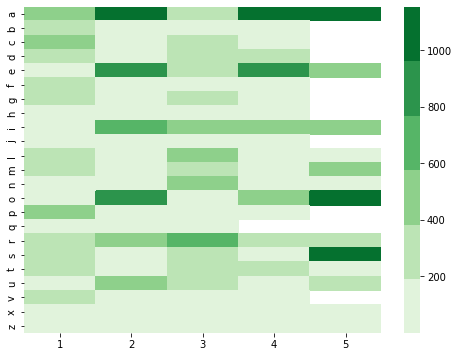

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df_termo_letras_posicao[[1, 2, 3, 4, 5]], cmap=sns.color_palette("Greens"))
plt.show()

Como podemos observar, algumas letras são claramente mais comuns em algumas posições. Por exemplo, as vogais em geral são mais comuns nas posições 2, 4 e 5, enquanto que a letra `"s"` é mais frequente na última posição (provavelmente devido as palavras no plural).

Logo esta pode ser uma boa abordagem. Para estimar a frequência neste caso, basta dividir a quantidade de letras contatada em cada posição para uma letra, pelo total de letras na respectiva posição (como todas as palavras tem o mesmo tamanho, e temos `5350` palavras no dataset, basta dividir cada elemento do dataset por `5350`).

Dess forma:

In [ ]:
df_termo_letras_posicao[1] = df_termo_letras_posicao[1]/df_termo_letras_posicao[1].sum()
df_termo_letras_posicao[2] = df_termo_letras_posicao[2]/df_termo_letras_posicao[2].sum()
df_termo_letras_posicao[3] = df_termo_letras_posicao[3]/df_termo_letras_posicao[3].sum()
df_termo_letras_posicao[4] = df_termo_letras_posicao[4]/df_termo_letras_posicao[4].sum()
df_termo_letras_posicao[5] = df_termo_letras_posicao[5]/df_termo_letras_posicao[5].sum()

In [ ]:
df_termo_letras_posicao.head(10)

,1,2,3,4,5
a,0.107664,0.187103,0.061682,0.215514,0.208411
b,0.050841,0.009720,0.021869,0.014579,NaN
c,0.100561,0.011963,0.052710,0.035888,NaN
d,0.042804,0.011028,0.038692,0.046355,NaN
e,0.033084,0.160000,0.052523,0.151028,0.106729
f,0.067290,0.008785,0.017009,0.005421,NaN
g,0.038879,0.006355,0.040187,0.024112,NaN
h,0.007477,0.008598,0.005421,0.021682,NaN
i,0.019626,0.117196,0.090467,0.083551,0.085981
j,0.012710,0.001495,0.013084,0.010654,NaN


E então desenhamos novamente o heatplot, agora com os valores anotados em cada retângulo:

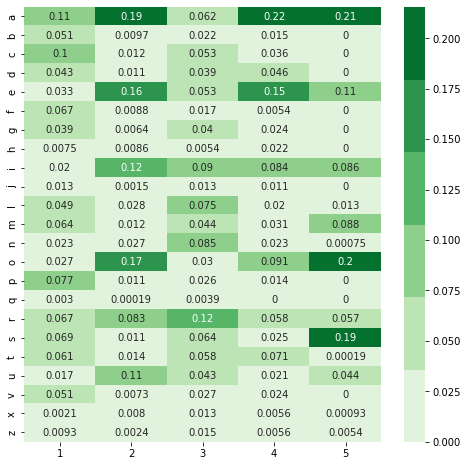

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(df_termo_letras_posicao[[1, 2, 3, 4, 5]].fillna(0), cmap=sns.color_palette("Greens"), annot=True)
plt.show()

## Ajustando os `DataFrames`

De todos os `DataFrames` criados, vamos utilizar apenas 3:

- O `DataFrame` `df_termo`, que contém o dataset limpo com as dados brutos (`"palavras"`), o total de letras (`"count"`) e as letras separadas em um lista (`"letras"`).



In [ ]:
df_termo.head()

,palavras,count,letras
0,abaco,5,"[a, b, a, c, o]"
1,abade,5,"[a, b, a, d, e]"
2,abafa,5,"[a, b, a, f, a]"
3,abafe,5,"[a, b, a, f, e]"
4,abafo,5,"[a, b, a, f, o]"


- O `DataFrame` `df_termo_letras` (modificado), que contém a soma do número de letras em cada posição para cada letra (colunas `1`, `2`, `3`, `4` e `5`), a soma destas da quantidade de cada letra (`"soma"`) e a frequência de cada letra (`"frequencia"`);

In [ ]:
df_termo_letras.head()

,1,2,3,4,5,soma,frequencia
a,576,1001,330,1153.0,1115.0,4175.0,0.156075
b,272,52,117,78.0,NaN,519.0,0.019402
c,538,64,282,192.0,NaN,1076.0,0.040224
d,229,59,207,248.0,NaN,743.0,0.027776
e,177,856,281,808.0,571.0,2693.0,0.100673


Para deixar este `DataFrame` consiso, vou remover todas as colunas com excessão da coluna `"frequencia"`, que é a coluna que contém a probabilidade de ocorrência de cada letra.

In [ ]:
df_prob = pd.DataFrame(data=df_termo_letras['frequencia'])
df_prob = df_prob.rename({'frequencia': "prob"}, axis=1)
df_prob.head()

,prob
a,0.156075
b,0.019402
c,0.040224
d,0.027776
e,0.100673


- E o `DataFrame` `df_termo_letras_posicao` (modificado), que contém as frequências relativas para cada letra em cada posição:

In [ ]:
df_prob_posicao = df_termo_letras_posicao.copy()
df_prob_posicao.head()

,1,2,3,4,5
a,0.107664,0.187103,0.061682,0.215514,0.208411
b,0.050841,0.009720,0.021869,0.014579,NaN
c,0.100561,0.011963,0.052710,0.035888,NaN
d,0.042804,0.011028,0.038692,0.046355,NaN
e,0.033084,0.160000,0.052523,0.151028,0.106729


Portanto, ficamos com estes dois `DataFrames`:

In [ ]:
# df_termo.to_csv("termo.csv", index=False)
# df_prob.to_csv("termo_prob.csv", index=True)
# df_prob_posicao.to_csv("termo_prob.csv", index=True)

# 3) Cálculo da "força" de cada palavra para o primeiro chute;


Agora que temos a probabilidade de ocorrência de cada letra podemos remover as palavras que tem letras repetidas. Como o interesse é em obter as duas primeiras palavra que vão maximizar as chances de descobrir as letras da palavras de chute, é melhor evitar palavras com letras repetidas; dessa forma, com apenas 2 chutes já testamos 10 letras diferentes. 

Para isto, vamos trabalhar com o `df_termo`. Precisamos descobrir quais palavras que contém letras repetidas. Para isto, vou utilizar uma função personalisada que retorna uma `list` de `str` sem as letras repetidas, mas que mantém a ordem inicial das letras:

In [ ]:
def unique(sequence):
  # source  https://stackoverflow.com/a/58666031/17872198
  seen = set()
  return [x for x in sequence if not (x in seen or seen.add(x))]

Por exemplo, observe o resultado retornado ao passar a palavra `"juliana"`:

In [ ]:
unique("juliana") 

['j', 'u', 'l', 'i', 'a', 'n']

Observe que a última letra `"a"` não é retornada, mas as letras com a ordem preservada.

Para aplicar esta função nas linhas do `DataFrame`, basta utilizar o método `apply`. Também vou aplicar o método `join` para transformar a lista retornada em uma `str`:

In [ ]:
df_termo['unicas'] = df_termo['palavras'].apply(unique).apply("".join)
df_termo.head()

,palavras,count,letras,unicas
0,abaco,5,"[a, b, a, c, o]",abco
1,abade,5,"[a, b, a, d, e]",abde
2,abafa,5,"[a, b, a, f, a]",abf
3,abafe,5,"[a, b, a, f, e]",abfe
4,abafo,5,"[a, b, a, f, o]",abfo


Agora podemos utilizar o método `str.len` para contar o número de letras em cada palavra da coluna `"unicas"`:

In [ ]:
df_termo['count_aux'] = df_termo['unicas'].str.len()
df_termo.head()

,palavras,count,letras,unicas,count_aux
0,abaco,5,"[a, b, a, c, o]",abco,4
1,abade,5,"[a, b, a, d, e]",abde,4
2,abafa,5,"[a, b, a, f, a]",abf,3
3,abafe,5,"[a, b, a, f, e]",abfe,4
4,abafo,5,"[a, b, a, f, o]",abfo,4


E então basta filtrar os dados para as linhas onde a coluna `"count_aux"` é igual a `5`:

In [ ]:
df_termo_sem_rep = df_termo.loc[df_termo['count_aux'] == 5].copy()
df_termo_sem_rep.reset_index(inplace=True, drop=True)
df_termo_sem_rep.head()

,palavras,count,letras,unicas,count_aux
0,abeto,5,"[a, b, e, t, o]",abeto,5
1,ablui,5,"[a, b, l, u, i]",ablui,5
2,abluo,5,"[a, b, l, u, o]",abluo,5
3,abole,5,"[a, b, o, l, e]",abole,5
4,aboli,5,"[a, b, o, l, i]",aboli,5


E o nosso conjunto amostral é reduzido quase pela metade:

In [ ]:
df_termo_sem_rep.shape[0]/df_termo.shape[0]

0.5766355140186916

## Calculo da força de cada palavra

A estratégia para calcular a força de cada palavra será a seguinte: 

1. Criar um `DataFrame` auxiliar com 5 colunas a partir do `DataFrame` `df_termo_sem_rep`, que representa a posição da letra na palavra, e em cada linha teremos uma palavra. Dessa forma, este `DataFrame` auxliar terá uma única letra em cada célula. Para isto, basta aplicar o método `to_list()` ao criar o `DataFrame` auxiliar;

2. Substituir em cada célula a frequência da respectiva letra, que é obtida do `DataFrame` `df_prob`. Como o `index` deste `DataFrame` corresponde a cada letra, podemos acessar a frequência correspondente com o próprio índice;

3. Somar todas as linhas com as probabilidades, resultando na "força" da palavra;

4. Concatenar os `DataFrames` `df_termo_sem_rep` e `def_aux`.


Então, 1)

In [ ]:
df_aux = pd.DataFrame(df_termo_sem_rep['letras'].to_list(), columns=[f"p{i}" for i in range(1,6)])
df_aux.head()

,p1,p2,p3,p4,p5
0,a,b,e,t,o
1,a,b,l,u,i
2,a,b,l,u,o
3,a,b,o,l,e
4,a,b,o,l,i


2)

In [ ]:
for i in df_prob.index:
  df_aux.replace(i, df_prob['prob'][i], inplace=True)
df_aux.head()

,p1,p2,p3,p4,p5
0,0.156075,0.019402,0.100673,0.040710,0.102280
1,0.156075,0.019402,0.037009,0.046542,0.079364
2,0.156075,0.019402,0.037009,0.046542,0.102280
3,0.156075,0.019402,0.102280,0.037009,0.100673
4,0.156075,0.019402,0.102280,0.037009,0.079364


3)

In [ ]:
df_aux['forca'] = df_aux.sum(axis=1)
df_aux.head()

,p1,p2,p3,p4,p5,forca
0,0.156075,0.019402,0.100673,0.040710,0.102280,0.419140
1,0.156075,0.019402,0.037009,0.046542,0.079364,0.338393
2,0.156075,0.019402,0.037009,0.046542,0.102280,0.361308
3,0.156075,0.019402,0.102280,0.037009,0.100673,0.415439
4,0.156075,0.019402,0.102280,0.037009,0.079364,0.394131


4)

In [ ]:
df_termo_sem_rep_full = pd.concat([df_termo_sem_rep, df_aux], axis=1)
df_termo_sem_rep_full.head()

,palavras,count,letras,unicas,count_aux,p1,p2,p3,p4,p5,forca
0,abeto,5,"[a, b, e, t, o]",abeto,5,0.156075,0.019402,0.100673,0.040710,0.102280,0.419140
1,ablui,5,"[a, b, l, u, i]",ablui,5,0.156075,0.019402,0.037009,0.046542,0.079364,0.338393
2,abluo,5,"[a, b, l, u, o]",abluo,5,0.156075,0.019402,0.037009,0.046542,0.102280,0.361308
3,abole,5,"[a, b, o, l, e]",abole,5,0.156075,0.019402,0.102280,0.037009,0.100673,0.415439
4,aboli,5,"[a, b, o, l, i]",aboli,5,0.156075,0.019402,0.102280,0.037009,0.079364,0.394131


Agora basta remover as colunas desnecessárias, e ordenar o `DataFrame` de forma crescente.

In [ ]:
df_best_first_word = pd.DataFrame(columns=['palavras', 'forca'])
df_best_first_word['palavras'] = df_termo_sem_rep_full['palavras']
df_best_first_word['forca'] = df_termo_sem_rep_full['forca']
df_best_first_word.sort_values(by="forca", ascending=False, inplace=True)
df_best_first_word.head(10)


,palavras,forca
2526,serao,0.509196
2420,rosea,0.509196
1933,orais,0.487888
2402,roias,0.487888
2379,roais,0.487888
2269,raios,0.487888
2494,sarei,0.486280
2527,seria,0.486280
2299,reais,0.486280
79,aires,0.486280


Assim, as palavras `serao` e `rosea` são as palavras com maior probabilidade de advinhar as letras presentas no termo do dia no primeiro chute. Como não estamos considerando a posição da letra na palavra, anagramas terão a mesma força (vamos resolver este problema em seguida).

Como temos muitas palavras com a mesma força, é interessante criar um ranking para as palavras, de forma a deixar mais claro qual é a ordem correta. Para isto, podemos aplicar o método `rank` na coluna `"forca"`, criando uma nova coluna `"rank"`:

In [ ]:
df_best_first_word['forca'] = df_best_first_word['forca'].round(7)

In [ ]:
df_best_first_word['rank'] = df_best_first_word['forca'].rank(ascending=False, method="dense").astype(int)
df_best_first_word.head(10)

,palavras,forca,rank
2526,serao,0.509196,1
2420,rosea,0.509196,1
1933,orais,0.487888,2
2402,roias,0.487888,2
2379,roais,0.487888,2
2269,raios,0.487888,2
2494,sarei,0.486280,3
2527,seria,0.486280,3
2299,reais,0.486280,3
79,aires,0.486280,3


Assim, é simples descobrir quantos grupos foram foramados de letras com a mesma força:

In [ ]:
df_best_first_word['rank'].max()

1554

E as piores palavras são:

In [ ]:
df_best_first_word.tail(10)

,palavras,forca,rank
1885,nudez,0.214168,1545
1083,fluxo,0.211514,1546
1175,fundi,0.205084,1547
1167,fulgi,0.204523,1548
1444,julho,0.202056,1549
3076,zumbi,0.200673,1550
1446,junho,0.196748,1551
1337,hindu,0.194019,1552
1389,induz,0.192860,1553
1197,fuzil,0.190093,1554


In [ ]:
df_best_first_word.to_csv("best.csv", index=False)

Então, a palavra `"fuzil"` é o pior chute possível!

## Cálculo da força de cada palavra por posição

In [ ]:
df_aux = pd.DataFrame(df_termo_sem_rep['letras'].to_list(), columns=range(1,6))
df_aux.head()

,1,2,3,4,5
0,a,b,e,t,o
1,a,b,l,u,i
2,a,b,l,u,o
3,a,b,o,l,e
4,a,b,o,l,i


In [ ]:
for column in df_prob_posicao.columns:
  for i in df_prob_posicao.index:
    df_aux[column].replace(i, df_prob_posicao[column][i], inplace=True)
df_aux.head()

,1,2,3,4,5
0,0.107664,0.00972,0.052523,0.070654,0.195327
1,0.107664,0.00972,0.074579,0.021495,0.085981
2,0.107664,0.00972,0.074579,0.021495,0.195327
3,0.107664,0.00972,0.030093,0.020374,0.106729
4,0.107664,0.00972,0.030093,0.020374,0.085981


In [ ]:
df_prob_posicao[1]["a"]

0.10766355140186916

In [ ]:
df_prob_posicao.head()

,1,2,3,4,5
a,0.107664,0.187103,0.061682,0.215514,0.208411
b,0.050841,0.009720,0.021869,0.014579,NaN
c,0.100561,0.011963,0.052710,0.035888,NaN
d,0.042804,0.011028,0.038692,0.046355,NaN
e,0.033084,0.160000,0.052523,0.151028,0.106729


In [ ]:
df_aux['forca'] = df_aux.sum(axis=1)
df_aux.head()

,1,2,3,4,5,forca
0,0.107664,0.00972,0.052523,0.070654,0.195327,0.435888
1,0.107664,0.00972,0.074579,0.021495,0.085981,0.299439
2,0.107664,0.00972,0.074579,0.021495,0.195327,0.408785
3,0.107664,0.00972,0.030093,0.020374,0.106729,0.274579
4,0.107664,0.00972,0.030093,0.020374,0.085981,0.253832


In [ ]:
df_termo_sem_rep_posicao = pd.concat([df_termo_sem_rep, df_aux], axis=1)
df_termo_sem_rep_posicao.head()

,palavras,count,letras,unicas,count_aux,1,2,3,4,5,forca
0,abeto,5,"[a, b, e, t, o]",abeto,5,0.107664,0.00972,0.052523,0.070654,0.195327,0.435888
1,ablui,5,"[a, b, l, u, i]",ablui,5,0.107664,0.00972,0.074579,0.021495,0.085981,0.299439
2,abluo,5,"[a, b, l, u, o]",abluo,5,0.107664,0.00972,0.074579,0.021495,0.195327,0.408785
3,abole,5,"[a, b, o, l, e]",abole,5,0.107664,0.00972,0.030093,0.020374,0.106729,0.274579
4,aboli,5,"[a, b, o, l, i]",aboli,5,0.107664,0.00972,0.030093,0.020374,0.085981,0.253832


In [ ]:
df_best_first_word_posicao = pd.DataFrame(columns=['palavras', 'forca'])
df_best_first_word_posicao['palavras'] = df_termo_sem_rep_posicao['palavras']
df_best_first_word_posicao['forca'] = df_termo_sem_rep_posicao['forca']
df_best_first_word_posicao.sort_values(by="forca", ascending=False, inplace=True)
df_best_first_word_posicao.head(10)


,palavras,forca
601,coras,0.799626
481,ceras,0.792523
2158,poras,0.776075
2054,peras,0.768972
1101,foras,0.766355
1772,moras,0.762804
2526,serao,0.761308
472,ceias,0.761308
2758,toras,0.759813
998,feras,0.759252


In [ ]:
df_best_first_word_posicao['rank'] = df_best_first_word_posicao['forca'].rank(ascending=False, method="dense").astype(int)
df_best_first_word_posicao.head(10)

,palavras,forca,rank
601,coras,0.799626,1
481,ceras,0.792523,2
2158,poras,0.776075,3
2054,peras,0.768972,4
1101,foras,0.766355,5
1772,moras,0.762804,6
2526,serao,0.761308,7
472,ceias,0.761308,7
2758,toras,0.759813,8
998,feras,0.759252,9


In [ ]:
df_best_first_word_posicao['rank'].max()

1951

In [ ]:
df_best_first_word_posicao.tail(10)

,palavras,forca,rank
1379,imune,0.204112,1942
1903,ocupe,0.203925,1943
904,escol,0.201121,1944
1354,icone,0.191215,1945
1391,infle,0.190467,1946
1368,ilhou,0.188785,1947
1373,imole,0.188411,1948
1410,isole,0.188224,1949
909,esqui,0.155888,1950
1389,induz,0.111963,1951


## Combando

In [ ]:
df_termo_sem_rep_posicao.head()

,palavras,count,letras,unicas,count_aux,1,2,3,4,5,forca
0,abeto,5,"[a, b, e, t, o]",abeto,5,0.107664,0.00972,0.052523,0.070654,0.195327,0.435888
1,ablui,5,"[a, b, l, u, i]",ablui,5,0.107664,0.00972,0.074579,0.021495,0.085981,0.299439
2,abluo,5,"[a, b, l, u, o]",abluo,5,0.107664,0.00972,0.074579,0.021495,0.195327,0.408785
3,abole,5,"[a, b, o, l, e]",abole,5,0.107664,0.00972,0.030093,0.020374,0.106729,0.274579
4,aboli,5,"[a, b, o, l, i]",aboli,5,0.107664,0.00972,0.030093,0.020374,0.085981,0.253832


In [ ]:
df_termo_sem_rep_full.head()

,palavras,count,letras,unicas,count_aux,p1,p2,p3,p4,p5,forca
0,abeto,5,"[a, b, e, t, o]",abeto,5,0.156075,0.019402,0.100673,0.040710,0.102280,0.419140
1,ablui,5,"[a, b, l, u, i]",ablui,5,0.156075,0.019402,0.037009,0.046542,0.079364,0.338393
2,abluo,5,"[a, b, l, u, o]",abluo,5,0.156075,0.019402,0.037009,0.046542,0.102280,0.361308
3,abole,5,"[a, b, o, l, e]",abole,5,0.156075,0.019402,0.102280,0.037009,0.100673,0.415439
4,aboli,5,"[a, b, o, l, i]",aboli,5,0.156075,0.019402,0.102280,0.037009,0.079364,0.394131


In [ ]:
df_best_first_word_combo = pd.DataFrame(columns=['palavras'])
df_best_first_word_combo['palavras'] = df_termo_sem_rep_posicao['palavras']
df_best_first_word_combo['forca_full'] = df_termo_sem_rep_full['forca']
df_best_first_word_combo['forca_posicao'] = df_termo_sem_rep_posicao['forca']
df_best_first_word_combo['forca'] = df_best_first_word_combo['forca_posicao'] * df_best_first_word_combo['forca_full']
df_best_first_word_combo.sort_values(by="forca", ascending=False, inplace=True)
df_best_first_word_combo.head(10)

,palavras,forca_full,forca_posicao,forca
2526,serao,0.509196,0.761308,0.387655
2700,terao,0.477047,0.753271,0.359345
601,coras,0.448748,0.799626,0.358830
2402,roias,0.487888,0.734953,0.358575
481,ceras,0.447140,0.792523,0.354369
1686,meiao,0.486280,0.725047,0.352576
1526,lerao,0.473346,0.741869,0.351161
1772,moras,0.456411,0.762804,0.348152
1703,meras,0.454804,0.755701,0.343696
472,ceias,0.449196,0.761308,0.341977


In [ ]:
df_best_first_word_combo['rank'] = df_best_first_word_combo['forca'].rank(ascending=False, method="dense").astype(int)
df_best_first_word_combo.head(10)

,palavras,forca_full,forca_posicao,forca,rank
2526,serao,0.509196,0.761308,0.387655,1
2700,terao,0.477047,0.753271,0.359345,2
601,coras,0.448748,0.799626,0.358830,3
2402,roias,0.487888,0.734953,0.358575,4
481,ceras,0.447140,0.792523,0.354369,5
1686,meiao,0.486280,0.725047,0.352576,6
1526,lerao,0.473346,0.741869,0.351161,7
1772,moras,0.456411,0.762804,0.348152,8
1703,meras,0.454804,0.755701,0.343696,9
472,ceias,0.449196,0.761308,0.341977,10


In [ ]:
df_best_first_word_combo['rank'].max()

3083

In [ ]:
df_best_first_word_combo.tail(10)

,palavras,forca_full,forca_posicao,forca,rank
1385,inche,0.260598,0.227477,0.059280,3074
1337,hindu,0.194019,0.300561,0.058314,3075
2845,ungir,0.256822,0.224112,0.057557,3076
876,enchi,0.260598,0.220187,0.057380,3077
1197,fuzil,0.190093,0.284673,0.054114,3078
3076,zumbi,0.200673,0.261121,0.052400,3079
1368,ilhou,0.273832,0.188785,0.051695,3080
1391,infle,0.268449,0.190467,0.051131,3081
909,esqui,0.300860,0.155888,0.046900,3082
1389,induz,0.192860,0.111963,0.021593,3083


# 4) Cálculo da "força" de cada palavra para os dois primeiros chutes;

Agora vamos buscar por um par de palavras com maximiza as chances de acerto nos *dois primeiros chutes*. Para isto é preciso criar um novo conjunto de dados, que deve conter duas colunas com a combinação de duas palavras. 

### Criando o DataFrame com todas as combinações únicas entre 2 palavras

Obter todas a combinações únicas todos os elementos de uma coluna de um `DataFrame` é muito simples, pois podemos utilizar a função `combinations` do pacote `itertools`. 

In [ ]:
from itertools import combinations

Esta função recebe como primeiro parâmetro o conjunto de dados (a coluna com os possíveis valores). Como segundo parâmetro, devemos passar o número de colunas que deve ser retornado. Como queremos as combinações únicas entre duas palavras, passamo o número dois como segundo parâmetro.

Contudo, devemos tomar muito cuidado para não utilizar muito memória ram ao realizar este procedimento. O nosso conjunto base de dados tem `5350` palavras, e cada palavra será combinada com todas as outras palavras (`5349`), o que vai gerar uma quantidade  grande de dados, que, se não forem abordados de forma adequada, podem acabar utilizando toda a memória ram do dispositivo.

Para calcular o número de combinações possíveis, podemos utilizar a função `special.comb` da biblioteca `scipy`:


In [ ]:
import scipy

In [ ]:
scipy.special.comb(5349, 2, exact=True)

14303226

Ou seja, vamos passar de 5349 linhas para pouco mais de 14 milhões de linhas (14303226)!

Mas como temos interesse em apenas as palavras que não repetem letras, não vamos utilizar o conjunto de dados completo, mas o reduzido:

In [ ]:
df_termo_sem_rep.shape

(3085, 5)

Com este `DataFrame` vamos gerar:


In [ ]:
scipy.special.comb(3085, 2, exact=True)

4757070

quase 5 milhões de combinações únicas (4757070 combinações). Apesar de ser um número grande, provavelmente não teremos problemas de memória (estou utilizando o Google Colab). 

Então, geramos as combinações de palavras:



In [ ]:
pares = combinations(df_termo_sem_rep['palavras'], 2)

A função `combinations` retorna um iterador:

In [ ]:
type(pares)

itertools.combinations

Para obter as combinações, basta transformar este iteratdor em uma `list`

In [ ]:
data = list(pares)
len(data)

4757070

In [ ]:
data[:10]

[('abeto', 'ablui'),
 ('abeto', 'abluo'),
 ('abeto', 'abole'),
 ('abeto', 'aboli'),
 ('abeto', 'abrem'),
 ('abeto', 'abres'),
 ('abeto', 'abreu'),
 ('abeto', 'abril'),
 ('abeto', 'abris'),
 ('abeto', 'abriu')]

Agora vamos transformar esta lista em um `DataFrame` para enfim estimar a força das duas palavras ao mesmo tempo:

In [ ]:
# , mas para  Para evitar possíveis problemas, ao invés de gerar as combinações de forma direta, vamos utilizar um gerador! 
# # Este gerador que vai gerar as combinações em blocos, reduzindo o armazenamento de dados na memória.
# # Para fazer isto, vou criar uma nova função:

# def generator_sol(anums1, s):
#       for comb in combinations(anums1, s):
#         yield comb
# pairs = generator_sol(df_termo_sem_rep['palavras'], 2)

# from more_itertools import chunked, ichunked

# # pairs = generator_sol(df_termo_sem_rep['palavras'], 2)
# # all_chunks = ichunked(pairs, 1000)
# # df_two = pd.DataFrame(columns=['palavra_1', 'palavra_2'])
# # a = True
# # while a:
# #   try:
# #     chunck_n = next(all_chunks)
# #   except: 
# #     a = False
# #   df_aux = pd.DataFrame(chunck_n, columns=['palavra_1', 'palavra_2'])
# #   df_two = pd.concat([df_two, df_aux], ignore_index=True)

# pairs = generator_sol(df_termo_sem_rep['palavras'], 3)
# all_chunks = ichunked(pairs, 1000)
# df_two = pd.DataFrame(columns=['palavra_1', 'palavra_2', 'palavra_3'])
# a = True
# while a:
#   try:
#     chunck_n = next(all_chunks)
#   except: 
#     a = False
#   df_aux = pd.DataFrame(chunck_n, columns=['palavra_1', 'palavra_2', 'palavra_3'])
#   df_two = pd.concat([df_two, df_aux], ignore_index=True)  

In [ ]:
df_two = pd.DataFrame(data, columns=["palavra_1", "palavra_2"])
df_two.head(10)

,palavra_1,palavra_2
0,abeto,ablui
1,abeto,abluo
2,abeto,abole
3,abeto,aboli
4,abeto,abrem
5,abeto,abres
6,abeto,abreu
7,abeto,abril
8,abeto,abris
9,abeto,abriu


In [ ]:
df_two.shape

(4757070, 2)

Como o nosso interesse é em maximizar as chances de acerto de palavras nos dois primeiros chutes, estamos interessados em combinações que não repetem letras. Então, é preciso filtrar o conjunto de dados para as combinações que resultam em duas palvras com letras distintas. 

Para fazer isto, vou somar as duas palavras, formando uma única palavara de 10 letras

In [ ]:
df_two['combined'] = df_two['palavra_1']+df_two['palavra_2']
df_two.head()

,palavra_1,palavra_2,combined
0,abeto,ablui,abetoablui
1,abeto,abluo,abetoabluo
2,abeto,abole,abetoabole
3,abeto,aboli,abetoaboli
4,abeto,abrem,abetoabrem


E então vou aplicar novamente a função `unique` juntamente com o `join` na coluna `"combined"`, gerando uma nova coluna com apenas as `str` únicas da combinação das duas palavras

In [ ]:
df_two['unique'] = df_two['combined'].apply(unique).apply("".join)
df_two.head()

,palavra_1,palavra_2,combined,unique
0,abeto,ablui,abetoablui,abetolui
1,abeto,abluo,abetoabluo,abetolu
2,abeto,abole,abetoabole,abetol
3,abeto,aboli,abetoaboli,abetoli
4,abeto,abrem,abetoabrem,abetorm


Agora contamos o número de letras na coluna `unique` utilizando o método `str.len()`

In [ ]:
df_two["count"] = df_two['unique'].str.len()
df_two.head()

,palavra_1,palavra_2,combined,unique,count
0,abeto,ablui,abetoablui,abetolui,8
1,abeto,abluo,abetoabluo,abetolu,7
2,abeto,abole,abetoabole,abetol,6
3,abeto,aboli,abetoaboli,abetoli,7
4,abeto,abrem,abetoabrem,abetorm,7


Finalmente, filtramos o `DataFrame` para obter apenas as combinações que retornam 10 letras diferentes:

In [ ]:
df_two_sem_rep = df_two[df_two['count'] == 10].copy()
df_two_sem_rep.reset_index(inplace=True, drop=True)
df_two_sem_rep.head()

,palavra_1,palavra_2,combined,unique,count
0,abeto,clips,abetoclips,abetoclips,10
1,abeto,cupim,abetocupim,abetocupim,10
2,abeto,cuspi,abetocuspi,abetocuspi,10
3,abeto,fluir,abetofluir,abetofluir,10
4,abeto,fluis,abetofluis,abetofluis,10


In [ ]:
df_two_sem_rep.shape

(278291, 5)

Dessa forma, o tamanho amostra é reduzido para menos do 6% quando comparado a todas as combinações únicas de duas palavras

In [ ]:
df_two_sem_rep.shape[0]/len(data)

0.058500505563298416

Agora basta seguir a mesma estratégia utilizada anteriormente para medir a força da combinação de duas palavras

## Cálculo da força das duas palavras globalmente

Começamos separando a coluna `"combined"` em uma lista de letras

In [ ]:
df_two_sem_rep['letras'] = df_two_sem_rep['combined'].apply(list)
df_two_sem_rep.head()

,palavra_1,palavra_2,combined,unique,count,letras
0,abeto,clips,abetoclips,abetoclips,10,"[a, b, e, t, o, c, l, i, p, s]"
1,abeto,cupim,abetocupim,abetocupim,10,"[a, b, e, t, o, c, u, p, i, m]"
2,abeto,cuspi,abetocuspi,abetocuspi,10,"[a, b, e, t, o, c, u, s, p, i]"
3,abeto,fluir,abetofluir,abetofluir,10,"[a, b, e, t, o, f, l, u, i, r]"
4,abeto,fluis,abetofluis,abetofluis,10,"[a, b, e, t, o, f, l, u, i, s]"


Então, criamos um novo `DataFrame` com cada letra em uma linha

In [ ]:
df_two_aux = pd.DataFrame(df_two_sem_rep['letras'].to_list(), columns=[f"p{i}" for i in range(1,11)]).copy()
df_two_aux.head()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10
0,a,b,e,t,o,c,l,i,p,s
1,a,b,e,t,o,c,u,p,i,m
2,a,b,e,t,o,c,u,s,p,i
3,a,b,e,t,o,f,l,u,i,r
4,a,b,e,t,o,f,l,u,i,s


Agora, substituimos cada letra por sua respectiva probabilidade em cada posição

In [ ]:
for i in df_prob.index:
  df_two_aux.replace(i, df_prob['prob'][i], inplace=True)
df_two_aux.head()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10
0,0.156075,0.019402,0.100673,0.04071,0.10228,0.040224,0.037009,0.079364,0.025607,0.072860
1,0.156075,0.019402,0.100673,0.04071,0.10228,0.040224,0.046542,0.025607,0.079364,0.047888
2,0.156075,0.019402,0.100673,0.04071,0.10228,0.040224,0.046542,0.072860,0.025607,0.079364
3,0.156075,0.019402,0.100673,0.04071,0.10228,0.019701,0.037009,0.046542,0.079364,0.077308
4,0.156075,0.019402,0.100673,0.04071,0.10228,0.019701,0.037009,0.046542,0.079364,0.072860


Então somamos as probabidalides em uma nova coluna `"forca"`:

In [ ]:
df_two_aux['forca'] = df_two_aux.sum(axis=1)
df_two_aux.head()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,forca
0,0.156075,0.019402,0.100673,0.04071,0.10228,0.040224,0.037009,0.079364,0.025607,0.072860,0.674206
1,0.156075,0.019402,0.100673,0.04071,0.10228,0.040224,0.046542,0.025607,0.079364,0.047888,0.658766
2,0.156075,0.019402,0.100673,0.04071,0.10228,0.040224,0.046542,0.072860,0.025607,0.079364,0.683738
3,0.156075,0.019402,0.100673,0.04071,0.10228,0.019701,0.037009,0.046542,0.079364,0.077308,0.679065
4,0.156075,0.019402,0.100673,0.04071,0.10228,0.019701,0.037009,0.046542,0.079364,0.072860,0.674617


Agora concatenamos os dados em um único `DataFrame`:

In [ ]:
df_two = pd.concat([df_two_sem_rep, df_two_aux], axis=1)
df_two.head()

,palavra_1,palavra_2,combined,unique,count,letras,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,forca
0,abeto,clips,abetoclips,abetoclips,10,"[a, b, e, t, o, c, l, i, p, s]",0.156075,0.019402,0.100673,0.04071,0.10228,0.040224,0.037009,0.079364,0.025607,0.072860,0.674206
1,abeto,cupim,abetocupim,abetocupim,10,"[a, b, e, t, o, c, u, p, i, m]",0.156075,0.019402,0.100673,0.04071,0.10228,0.040224,0.046542,0.025607,0.079364,0.047888,0.658766
2,abeto,cuspi,abetocuspi,abetocuspi,10,"[a, b, e, t, o, c, u, s, p, i]",0.156075,0.019402,0.100673,0.04071,0.10228,0.040224,0.046542,0.072860,0.025607,0.079364,0.683738
3,abeto,fluir,abetofluir,abetofluir,10,"[a, b, e, t, o, f, l, u, i, r]",0.156075,0.019402,0.100673,0.04071,0.10228,0.019701,0.037009,0.046542,0.079364,0.077308,0.679065
4,abeto,fluis,abetofluis,abetofluis,10,"[a, b, e, t, o, f, l, u, i, s]",0.156075,0.019402,0.100673,0.04071,0.10228,0.019701,0.037009,0.046542,0.079364,0.072860,0.674617


Por fim, limpamos o `DataFrame` para deixar apenas as duas palavras e a probabilidade estimada

In [ ]:
df_first_second_best = pd.DataFrame(columns=['palavra_1', 'palavra_2', 'forca'])
df_first_second_best['palavra_1'] = df_two_sem_rep['palavra_1']
df_first_second_best['palavra_2'] = df_two_sem_rep['palavra_2']
df_first_second_best['forca'] = df_two_aux['forca']
df_first_second_best.sort_values(by="forca", ascending=False, inplace=True)
df_first_second_best.reset_index(inplace=True, drop=True)
df_first_second_best.head(10)

,palavra_1,palavra_2,forca
0,casou,tirem,0.763925
1,coeis,turma,0.763925
2,curia,tosem,0.763925
3,casem,tirou,0.763925
4,curia,tomes,0.763925
5,catou,remis,0.763925
6,meias,truco,0.763925
7,astro,ciume,0.763925
8,catou,rimes,0.763925
9,curai,tosem,0.763925


Encontramos diversos pares de palavras que maximizam as chances de acerto nos dois primeiros chutes. A chance de acerto chega a 0.764, que é bastante interessante.

Atente que estas palavras envolvem a presença das cinco vogais (`"a"`, `"e"`, `"i"`, `"o"` e `"u"`), e de 5 consoantes (`"c"`, `"s"`, `"t"`, `"r"` e `"m"`), que são as 10 palavras mais frequentes em palavras de 5 letras.

Para melhorar os resultados, podemos adicionar uma coluna com o ranking as palavras. Entretanto, para evitar problemas em relação a precisão dos números, vou arrendondar a coluna `"forca"` para 7 dígitos antes de criar o ranqueamento: 



In [ ]:
df_first_second_best['forca'] = df_first_second_best['forca'].round(7)

In [ ]:
df_first_second_best['rank'] = df_first_second_best['forca'].rank(ascending=False, method="dense").astype(int)
df_first_second_best.head(10)

,palavra_1,palavra_2,forca,rank
0,casou,tirem,0.763925,1
1,coeis,turma,0.763925,1
2,curia,tosem,0.763925,1
3,casem,tirou,0.763925,1
4,curia,tomes,0.763925,1
5,catou,remis,0.763925,1
6,meias,truco,0.763925,1
7,astro,ciume,0.763925,1
8,catou,rimes,0.763925,1
9,curai,tosem,0.763925,1


Para saber quantas combinações de duas palavras foram ranqueadas como número 1, basta utilizar um filtro:

In [ ]:
df_first_second_best[df_first_second_best['rank'] == 1]

,palavra_1,palavra_2,forca,rank
0,casou,tirem,0.763925,1
1,coeis,turma,0.763925,1
2,curia,tosem,0.763925,1
3,casem,tirou,0.763925,1
4,curia,tomes,0.763925,1
...,...,...,...,...
307,cuias,termo,0.763925,1
308,cuias,temor,0.763925,1
309,corte,sumia,0.763925,1
310,curso,metia,0.763925,1


Ou seja, temos 312 combinações de duas palavras que maximizam as chances de acertar pelo menos 1 letra nos dois primeiros chutes.

As 10 piores combinações de duas palavras são:

In [ ]:
df_first_second_best.tail(10)

,palavra_1,palavra_2,forca,rank
278281,fuzil,venho,0.455252,5967
278282,benzi,julgo,0.453944,5968
278283,clips,junho,0.451813,5969
278284,junho,petiz,0.450579,5970
278285,fixem,junho,0.450355,5971
278286,benzi,fluxo,0.450131,5972
278287,junho,pixel,0.445383,5973
278288,feliz,junho,0.440972,5974
278289,benzi,julho,0.440673,5975
278290,felix,junho,0.439477,5976


Portanto, temos 312 combinações de 2 palavras que maximizam as chances dos dois primeiros chutes.

## Cálculo da força de duas palavras por posição

Agora vamos considerar o peso da posição das letras para estimar a força das palavras. Iniciamos construindo um `DataFrame´ auxiliar com as em cada célula:

In [ ]:
df_two_aux = pd.DataFrame(df_two_sem_rep['letras'].to_list(), columns=range(1,11)).copy()
df_two_aux.head()

,1,2,3,4,5,6,7,8,9,10
0,a,b,e,t,o,c,l,i,p,s
1,a,b,e,t,o,c,u,p,i,m
2,a,b,e,t,o,c,u,s,p,i
3,a,b,e,t,o,f,l,u,i,r
4,a,b,e,t,o,f,l,u,i,s


Agora basta substituir cada célula pela chance de cada palavra, mas utilizando os pesos definidos no `DataFrame` `df_prob_posicao`:

In [ ]:
for column in df_prob_posicao.columns:
  for i in df_prob_posicao.index:
    df_two_aux[column].replace(i, df_prob_posicao[column][i], inplace=True)
    df_two_aux[column+5].replace(i, df_prob_posicao[column][i], inplace=True)

df_two_aux.head()

,1,2,3,4,5,6,7,8,9,10
0,0.107664,0.00972,0.052523,0.070654,0.195327,0.100561,0.028224,0.090467,0.014393,0.194766
1,0.107664,0.00972,0.052523,0.070654,0.195327,0.100561,0.106729,0.025794,0.083551,0.088224
2,0.107664,0.00972,0.052523,0.070654,0.195327,0.100561,0.106729,0.064299,0.014393,0.085981
3,0.107664,0.00972,0.052523,0.070654,0.195327,0.067290,0.028224,0.043364,0.083551,0.056636
4,0.107664,0.00972,0.052523,0.070654,0.195327,0.067290,0.028224,0.043364,0.083551,0.194766


Observe que como temos 10 colunas, onde a primeira e a sexta indicam o começo da primeira e da segunda palavra, respectivamente, precisamos percorrer duas vezes o `df_two_aux`, uma vez para cada palavra.

Agora é preciso somar a força das 10 letras

In [ ]:
df_two_aux['forca'] = df_two_aux.sum(axis=1)
df_two_aux.head()

,1,2,3,4,5,6,7,8,9,10,forca
0,0.107664,0.00972,0.052523,0.070654,0.195327,0.100561,0.028224,0.090467,0.014393,0.194766,0.864299
1,0.107664,0.00972,0.052523,0.070654,0.195327,0.100561,0.106729,0.025794,0.083551,0.088224,0.840748
2,0.107664,0.00972,0.052523,0.070654,0.195327,0.100561,0.106729,0.064299,0.014393,0.085981,0.807850
3,0.107664,0.00972,0.052523,0.070654,0.195327,0.067290,0.028224,0.043364,0.083551,0.056636,0.714953
4,0.107664,0.00972,0.052523,0.070654,0.195327,0.067290,0.028224,0.043364,0.083551,0.194766,0.853084


In [ ]:
df_termo_sem_rep_posicao = pd.concat([df_two_sem_rep, df_two_aux], axis=1)
df_termo_sem_rep_posicao.head()

,palavra_1,palavra_2,combined,unique,count,letras,1,2,3,4,5,6,7,8,9,10,forca
0,abeto,clips,abetoclips,abetoclips,10,"[a, b, e, t, o, c, l, i, p, s]",0.107664,0.00972,0.052523,0.070654,0.195327,0.100561,0.028224,0.090467,0.014393,0.194766,0.864299
1,abeto,cupim,abetocupim,abetocupim,10,"[a, b, e, t, o, c, u, p, i, m]",0.107664,0.00972,0.052523,0.070654,0.195327,0.100561,0.106729,0.025794,0.083551,0.088224,0.840748
2,abeto,cuspi,abetocuspi,abetocuspi,10,"[a, b, e, t, o, c, u, s, p, i]",0.107664,0.00972,0.052523,0.070654,0.195327,0.100561,0.106729,0.064299,0.014393,0.085981,0.807850
3,abeto,fluir,abetofluir,abetofluir,10,"[a, b, e, t, o, f, l, u, i, r]",0.107664,0.00972,0.052523,0.070654,0.195327,0.067290,0.028224,0.043364,0.083551,0.056636,0.714953
4,abeto,fluis,abetofluis,abetofluis,10,"[a, b, e, t, o, f, l, u, i, s]",0.107664,0.00972,0.052523,0.070654,0.195327,0.067290,0.028224,0.043364,0.083551,0.194766,0.853084


In [ ]:
df_best_first_second_word_posicao = pd.DataFrame(columns=['palavra_1', 'palavra_2', 'forca'])
df_best_first_second_word_posicao['palavra_1'] = df_termo_sem_rep_posicao['palavra_1']
df_best_first_second_word_posicao['palavra_2'] = df_termo_sem_rep_posicao['palavra_2']
df_best_first_second_word_posicao['forca'] = df_termo_sem_rep_posicao['forca']
df_best_first_second_word_posicao.sort_values(by="forca", ascending=False, inplace=True)
df_best_first_second_word_posicao.head(10)


,palavra_1,palavra_2,forca
105513,cures,pilao,1.354393
105409,cures,filao,1.344673
64718,ceras,pinto,1.338131
77946,cinto,peras,1.338131
98759,cuias,perto,1.332710
104952,curas,peito,1.332710
64672,ceras,finto,1.328411
65314,certo,finas,1.328411
239057,munes,pirao,1.328411
64445,cento,firas,1.328411


In [ ]:
df_best_first_second_word_posicao['forca'] = df_best_first_second_word_posicao['forca'].round(7)

In [ ]:
df_best_first_second_word_posicao['rank'] = df_best_first_second_word_posicao['forca'].rank(ascending=False, method="dense").astype(int)
df_best_first_second_word_posicao.head(10)

,palavra_1,palavra_2,forca,rank
105513,cures,pilao,1.354393,1
105409,cures,filao,1.344673,2
64718,ceras,pinto,1.338131,3
77946,cinto,peras,1.338131,3
98759,cuias,perto,1.332710,4
104952,curas,peito,1.332710,4
64672,ceras,finto,1.328411,5
65314,certo,finas,1.328411,5
239057,munes,pirao,1.328411,5
64445,cento,firas,1.328411,5


In [ ]:
df_best_first_second_word_posicao.tail(10)

,palavra_1,palavra_2,forca,rank
8739,aloje,induz,0.395327,4225
16028,atole,induz,0.391215,4226
201516,induz,obste,0.390841,4227
10190,amole,induz,0.388411,4228
382,abole,induz,0.386542,4229
71044,chove,induz,0.382056,4230
5653,afobe,induz,0.379813,4231
187340,glose,induz,0.340935,4232
137424,expor,induz,0.326916,4233
135375,escol,induz,0.313084,4234


## Combando

In [ ]:
df_termo_sem_rep_posicao.head()

,palavra_1,palavra_2,combined,unique,count,letras,1,2,3,4,5,6,7,8,9,10,forca
0,abeto,clips,abetoclips,abetoclips,10,"[a, b, e, t, o, c, l, i, p, s]",0.107664,0.00972,0.052523,0.070654,0.195327,0.100561,0.028224,0.090467,0.014393,0.194766,0.864299
1,abeto,cupim,abetocupim,abetocupim,10,"[a, b, e, t, o, c, u, p, i, m]",0.107664,0.00972,0.052523,0.070654,0.195327,0.100561,0.106729,0.025794,0.083551,0.088224,0.840748
2,abeto,cuspi,abetocuspi,abetocuspi,10,"[a, b, e, t, o, c, u, s, p, i]",0.107664,0.00972,0.052523,0.070654,0.195327,0.100561,0.106729,0.064299,0.014393,0.085981,0.807850
3,abeto,fluir,abetofluir,abetofluir,10,"[a, b, e, t, o, f, l, u, i, r]",0.107664,0.00972,0.052523,0.070654,0.195327,0.067290,0.028224,0.043364,0.083551,0.056636,0.714953
4,abeto,fluis,abetofluis,abetofluis,10,"[a, b, e, t, o, f, l, u, i, s]",0.107664,0.00972,0.052523,0.070654,0.195327,0.067290,0.028224,0.043364,0.083551,0.194766,0.853084


In [ ]:
df_two.head()

,palavra_1,palavra_2,combined,unique,count,letras,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,forca
0,abeto,clips,abetoclips,abetoclips,10,"[a, b, e, t, o, c, l, i, p, s]",0.156075,0.019402,0.100673,0.04071,0.10228,0.040224,0.037009,0.079364,0.025607,0.072860,0.674206
1,abeto,cupim,abetocupim,abetocupim,10,"[a, b, e, t, o, c, u, p, i, m]",0.156075,0.019402,0.100673,0.04071,0.10228,0.040224,0.046542,0.025607,0.079364,0.047888,0.658766
2,abeto,cuspi,abetocuspi,abetocuspi,10,"[a, b, e, t, o, c, u, s, p, i]",0.156075,0.019402,0.100673,0.04071,0.10228,0.040224,0.046542,0.072860,0.025607,0.079364,0.683738
3,abeto,fluir,abetofluir,abetofluir,10,"[a, b, e, t, o, f, l, u, i, r]",0.156075,0.019402,0.100673,0.04071,0.10228,0.019701,0.037009,0.046542,0.079364,0.077308,0.679065
4,abeto,fluis,abetofluis,abetofluis,10,"[a, b, e, t, o, f, l, u, i, s]",0.156075,0.019402,0.100673,0.04071,0.10228,0.019701,0.037009,0.046542,0.079364,0.072860,0.674617


In [ ]:
df_best_first_second_word_combo = pd.DataFrame(columns=['palavra_1', "palavra_2"])
df_best_first_second_word_combo['palavra_1'] = df_two['palavra_1']
df_best_first_second_word_combo['palavra_2'] = df_two['palavra_2']
df_best_first_second_word_combo['forca_full'] = df_two['forca']
df_best_first_second_word_combo['forca_posicao'] = df_termo_sem_rep_posicao['forca']
df_best_first_second_word_combo['forca'] = df_best_first_second_word_combo['forca_posicao'] * df_best_first_second_word_combo['forca_full']
df_best_first_second_word_combo.sort_values(by="forca", ascending=False, inplace=True)
df_best_first_second_word_combo.head(10)

,palavra_1,palavra_2,forca_full,forca_posicao,forca
107134,curto,meias,0.763925,1.319439,1.007953
64710,ceras,muito,0.763925,1.319439,1.007953
105513,cures,pilao,0.737944,1.354393,0.999466
105537,cures,timao,0.763925,1.308037,0.999243
65383,certo,minas,0.749084,1.324860,0.992431
77919,cinto,meras,0.749084,1.324860,0.992431
64707,ceras,minto,0.749084,1.324860,0.992431
64543,cento,miras,0.749084,1.324860,0.992431
102136,cumes,pirao,0.748822,1.324299,0.991665
104952,curas,peito,0.741645,1.332710,0.988398


In [ ]:
df_best_first_second_word_combo['forca'] = df_best_first_second_word_combo['forca'].round(7)

In [ ]:
df_best_first_second_word_combo['rank'] = df_best_first_second_word_combo['forca'].rank(ascending=False, method="dense").astype(int)
df_best_first_second_word_combo.head(10)

,palavra_1,palavra_2,forca_full,forca_posicao,forca,rank
107134,curto,meias,0.763925,1.319439,1.007953,1
64710,ceras,muito,0.763925,1.319439,1.007953,1
105513,cures,pilao,0.737944,1.354393,0.999466,2
105537,cures,timao,0.763925,1.308037,0.999243,3
65383,certo,minas,0.749084,1.324860,0.992431,4
77919,cinto,meras,0.749084,1.324860,0.992431,4
64707,ceras,minto,0.749084,1.324860,0.992431,4
64543,cento,miras,0.749084,1.324860,0.992431,4
102136,cumes,pirao,0.748822,1.324299,0.991665,5
104952,curas,peito,0.741645,1.332710,0.988398,6


In [ ]:
df_best_first_second_word_combo.tail(10)

,palavra_1,palavra_2,forca_full,forca_posicao,forca,rank
70545,chore,induz,0.521981,0.416262,0.217281,236044
67563,chave,induz,0.520336,0.413645,0.215234,236045
201582,induz,plote,0.499140,0.424673,0.211971,236046
30839,blefo,induz,0.471925,0.444299,0.209676,236047
201516,induz,obste,0.528785,0.390841,0.206671,236048
201522,induz,olhem,0.489346,0.412336,0.201775,236049
187340,glose,induz,0.527589,0.340935,0.179873,236050
71044,chove,induz,0.466542,0.382056,0.178245,236051
135375,escol,induz,0.545907,0.313084,0.170915,236052
137424,expor,induz,0.504710,0.326916,0.164998,236053
